# Quick Start

The easiest way to get up and running is to load in one of our example datasets (or load in some data of your own) and to convert them to either a [HindcastEnsemble](api/climpred.classes.HindcastEnsemble.html#climpred.classes.HindcastEnsemble) or [PerfectModelEnsemble](api/climpred.classes.PerfectModelEnsemble.html#climpred.classes.PerfectModelEnsemble) object.

`climpred` provides example datasets from the MPI-ESM-LR decadal prediction ensemble and the CESM decadal prediction ensemble. See our [examples](examples.html) to see some analysis cases.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr

from climpred import HindcastEnsemble
from climpred.tutorial import load_dataset
import climpred

You can view the datasets available to be loaded with the [load_datasets()](api/climpred.tutorial.load_dataset.html#climpred.tutorial.load_dataset) command without passing any arguments:

In [2]:
load_dataset()

'MPI-control-1D': area averages for the MPI control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the MPI control run of SST/SSS.
'MPI-PM-DP-1D': perfect model decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-PM-DP-3D': perfect model decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'CESM-DP-SST': hindcast decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': hindcast decadal prediction ensemble of global mean SSS.
'CESM-DP-SST-3D': hindcast decadal prediction ensemble of eastern Pacific SSTs.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': hindcast initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.
'FOSI

From here, loading a dataset is easy. Note that you need to be connected to the internet for this to work -- the datasets are being pulled from the [climpred-data](https://github.com/bradyrx/climpred-data) repository. Once loaded, it is cached on your computer so you can reload extremely quickly. These datasets are very small (< 1MB each) so they won't take up much space.

In [3]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST')
# Add lead attribute units.
hind["lead"].attrs["units"] = "years"
obs = climpred.tutorial.load_dataset('ERSST')

Make sure your prediction ensemble's dimension labeling conforms to `climpred`'s [standards](setting-up-data.html). In other words, you need an `init`, `lead`, and (optional) `member` dimension. Make sure that your `init` and `lead` dimensions align. *E.g.*, a November 1st, 1954 initialization should be labeled as `init=1954` so that the lead=1 forecast is 1955.

In [4]:
print(hind)

<xarray.Dataset>
Dimensions:  (init: 64, lead: 10, member: 10)
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10
  * init     (init) float32 1954.0 1955.0 1956.0 1957.0 ... 2015.0 2016.0 2017.0
Data variables:
    SST      (init, lead, member) float64 ...


We'll quickly process the data to create anomalies. CESM-DPLE's drift-correction occurs over 1964-2014, so we'll remove that from the observations.

In [5]:
# subtract climatology
obs = obs - obs.sel(time=slice(1964, 2014)).mean()

We'll also remove a linear trend so that it doesn't artificially boost our predictability.

In [6]:
hind = climpred.stats.rm_trend(hind, dim='init')
obs = climpred.stats.rm_trend(obs, dim='time')

We have to add the lead attributes back on, because `xarray` sometimes drops attributes. This is a bug we're aware of that we are working on fixing for `climpred`.

In [7]:
# Add lead attribute units.
hind["lead"].attrs["units"] = "years"

We can now create a [HindcastEnsemble](api/climpred.classes.HindcastEnsemble.html#climpred.classes.HindcastEnsemble) object and add our observations and name them `'Obs'`.

In [8]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(obs, 'Obs')
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 0.005165 0.03014 ... 0.1842 0.1812
Obs:
    SST      (time) float32 -0.061960407 -0.023283795 ... 0.072058104 0.165859
Uninitialized:
    None


/Users/ribr5703/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


Now we'll quickly calculate skill and persistence. We have a variety of possible [metrics](https://climpred.readthedocs.io/en/latest/metrics.html) to use. 

In [9]:
result = hindcast.verify(metric='acc', reference='persistence')
skill = result.sel(skill='init')
persistence = result.sel(skill='persistence')
print(skill)

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
    skill    <U11 'init'
Data variables:
    SST      (lead) float64 0.6253 0.4349 0.3131 ... 0.1861 0.01881 -0.1084


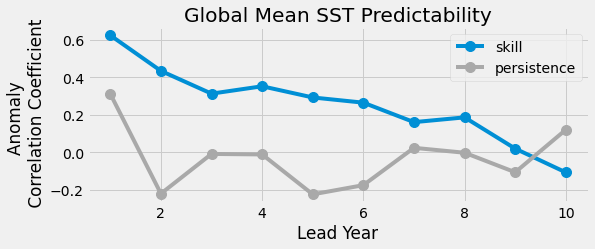

In [10]:
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(8, 3))
skill.SST.plot(marker='o', markersize=10, label='skill')
persistence.SST.plot(marker='o', markersize=10, label='persistence',
                     color='#a9a9a9')
plt.legend()
ax.set(title='Global Mean SST Predictability',
       ylabel='Anomaly \n Correlation Coefficient',
       xlabel='Lead Year')
plt.show()

We can also check error in our forecasts.

In [12]:
result = hindcast.verify(metric='rmse', reference='persistence')
skill = result.sel(skill='init')
persistence = result.sel(skill='persistence')

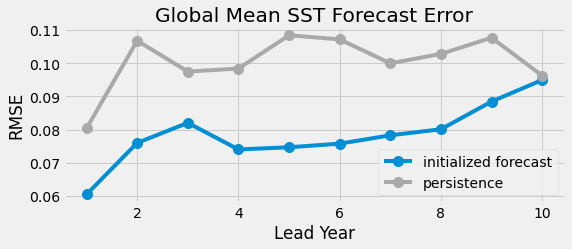

In [13]:
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(8, 3))
skill.SST.plot(marker='o', markersize=10, label='initialized forecast')
persistence.SST.plot(marker='o', markersize=10, label='persistence',
                     color='#a9a9a9')
plt.legend()
ax.set(title='Global Mean SST Forecast Error',
       ylabel='RMSE',
       xlabel='Lead Year')
plt.show()